In [1]:
import git
from pathlib import Path
import os
from matplotlib import colors

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
np.random.seed(0)

In [2]:
SAVE_FIGS = True
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")

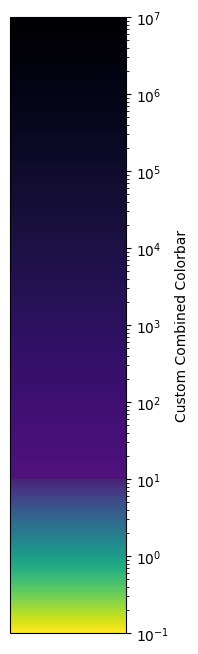

In [3]:
from matplotlib.colors import ListedColormap, LogNorm
import numpy as np
import matplotlib.pyplot as plt

# Set the split ratio (e.g., 0.25 means 25% viridis_r, 75% magma_r)
split_ratio = 0.25
n_total = 256
n1 = int(n_total * split_ratio)
n2 = n_total - n1

# Get color arrays from the colormaps
viridis_r = plt.get_cmap('viridis_r')(np.linspace(0, 0.9, n1))
magma_r = plt.get_cmap('magma_r')(np.linspace(0.75, 1, n2))

# Concatenate the color arrays
combined_colors = np.vstack([viridis_r, magma_r])
custom_cmap = ListedColormap(combined_colors)
def color_fn(variance):
        return custom_cmap(norm(variance))

# Create a colorbar for demonstration
fig, ax = plt.subplots(figsize=(1.5, 8))
norm = LogNorm(vmin=0.1, vmax=1e7)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax)
cb.set_label('Custom Combined Colorbar')
plt.show()

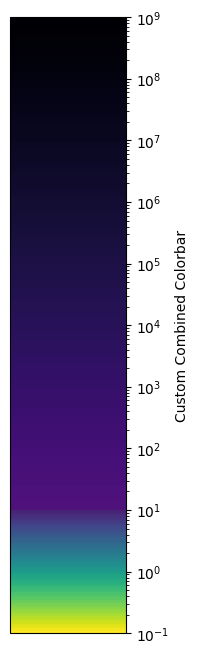

In [4]:
from matplotlib.colors import ListedColormap, LogNorm
import numpy as np
import matplotlib.pyplot as plt

# Set the split ratio (e.g., 0.25 means 25% viridis_r, 75% magma_r)
split_ratio = 0.2
n_total = 256
n1 = int(n_total * split_ratio)
n2 = n_total - n1

# Get color arrays from the colormaps
viridis_r = plt.get_cmap('viridis_r')(np.linspace(0, 0.9, n1))
magma_r = plt.get_cmap('magma_r')(np.linspace(0.75, 1, n2))

# Concatenate the color arrays
combined_colors = np.vstack([viridis_r, magma_r])
custom_cmap = ListedColormap(combined_colors)
def color_fn(variance):
        return custom_cmap(norm(variance))

# Create a colorbar for demonstration
fig, ax = plt.subplots(figsize=(1.5, 8))
norm = LogNorm(vmin=0.1, vmax=1e9)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax)
cb.set_label('Custom Combined Colorbar')
plt.show()

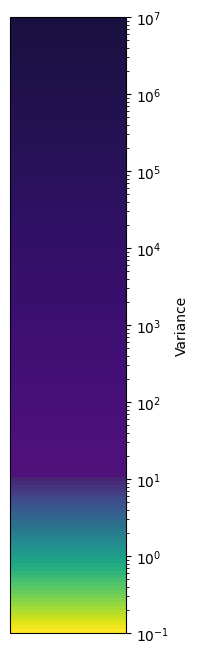

In [5]:
from matplotlib.colors import ListedColormap, LogNorm
import numpy as np
import matplotlib.pyplot as plt

# Set the split ratio (e.g., 0.25 means 25% viridis_r, 75% magma_r)
split_ratio = 0.16
n_total = 256
n1 = int(n_total * split_ratio)
n2 = n_total - n1

# Get color arrays from the colormaps
viridis_r = plt.get_cmap('viridis_r')(np.linspace(0, 0.9, n1))
magma_r = plt.get_cmap('magma_r')(np.linspace(0.75, 1, n2))

# Concatenate the color arrays
combined_colors = np.vstack([viridis_r, magma_r])
custom_cmap = ListedColormap(combined_colors)
def color_fn(variance):
        return custom_cmap(norm(variance))

# Create a colorbar for demonstration
fig, ax = plt.subplots(figsize=(1.5, 8))
norm = LogNorm(vmin=0.1, vmax=1e12)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax)
cb.set_label('Variance')
plt.ylim((1e-1, 1e7))
plt.show()
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"varianceColorBar.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# Laplace

Params: 1, -0.5
Chebyshev bound: 31.622776601683793
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.021889454375984163


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values with new points: 0.0005115249956635926
First CDF value: 1.89078966425973e-20
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.007433844363674877, pvalue=0.635515787286349, statistic_location=-1.3125208513784867, statistic_sign=-1)
[2.39789527 1.70474809 1.29928298 1.01160091 0.78845736 0.6061358
 0.45198512 0.31845373 0.2006707  0.09531018]


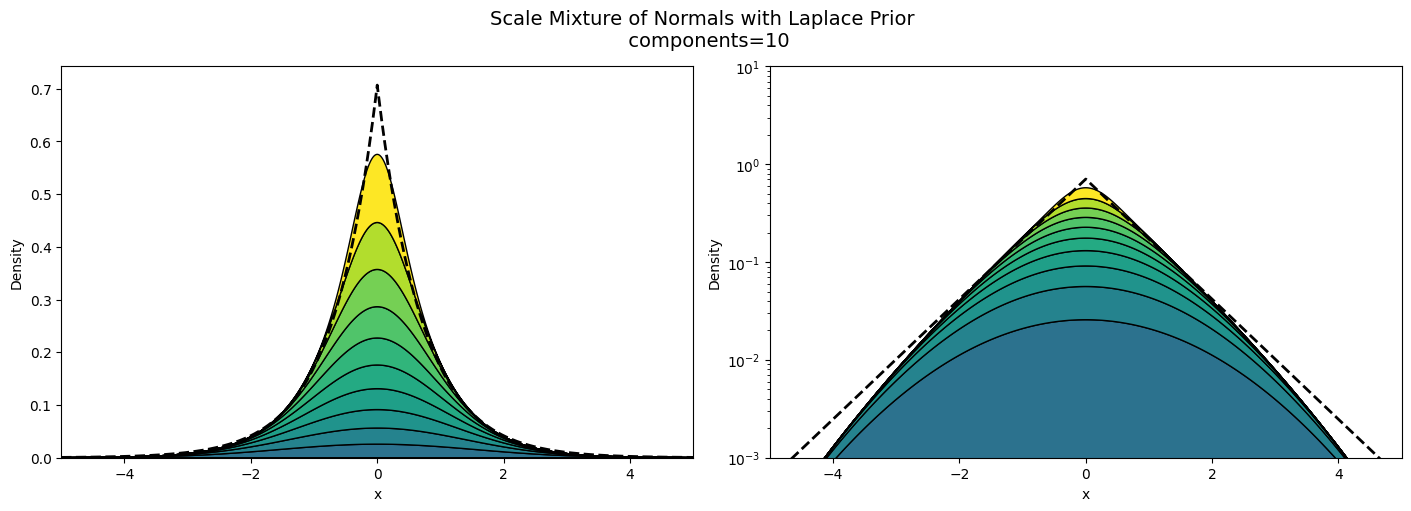

In [6]:
title = f'Scale Mixture of Normals with Laplace Prior \n components={10}'
fig = plot_pdf_components(r=1, eta=-0.5, scale=1, components=10, mode="equal", color_fn= color_fn,  xlim=(-5, 5),  log_lim=(1e-3, 10), title= title, debug=True)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_laplace.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 1, -0.5
Chebyshev bound: 31.622776601683793
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.021889454375984163


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values with new points: 0.0005115249956635926
First CDF value: 1.89078966425973e-20
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.008427765997517711, pvalue=0.47380779234523007, statistic_location=0.7946177815504543, statistic_sign=1)
[8.00670085e+00 7.31355366e+00 6.90808856e+00 ... 1.00016678e-03
 6.66666691e-04 3.33277790e-04]


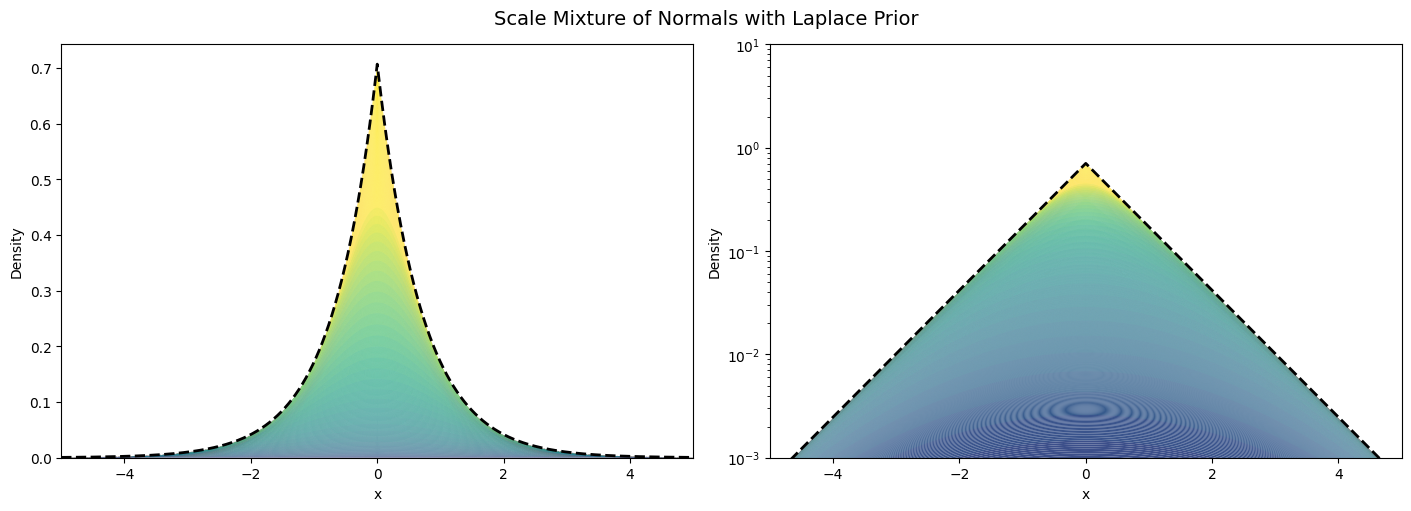

In [7]:
title = f'Scale Mixture of Normals with Laplace Prior'
fig = plot_pdf_components(r=1, eta=-0.5, scale=1, components=3000, mode="equal", color_fn= color_fn,  xlim=(-5, 5),  log_lim=(1e-3, 10), title= title, debug=True, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_laplace.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# Cauchy

[153.39444921  37.84530946  16.44323933   8.94736277   5.4716053
   3.57594654   2.42337383   1.66254072   1.12189402   0.69974073]


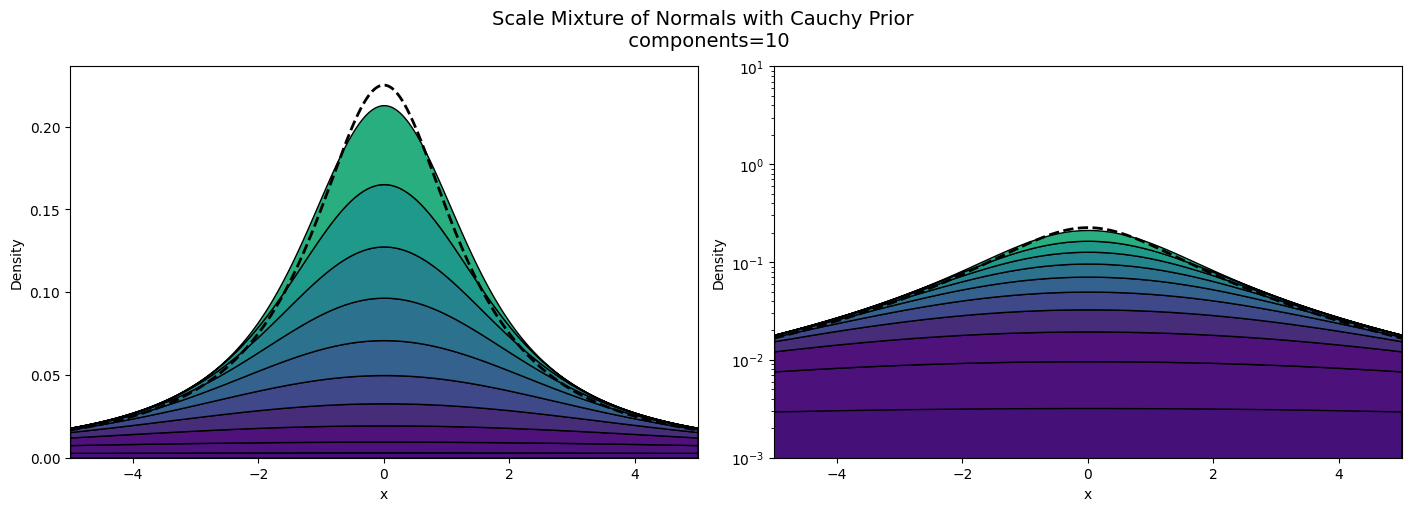

In [8]:
title = f'Scale Mixture of Normals with Cauchy Prior \n components={10}'
fig = plot_pdf_components(r=-1, eta=-2, scale=1, components=10, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), debug=True, prior_pdf=stats.cauchy(0,np.sqrt(2)).pdf, title=title)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_cauchy.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

[1.14667959e+07 2.86669849e+06 1.27408785e+06 ... 1.84703191e-01
 1.72703046e-01 1.55354824e-01]


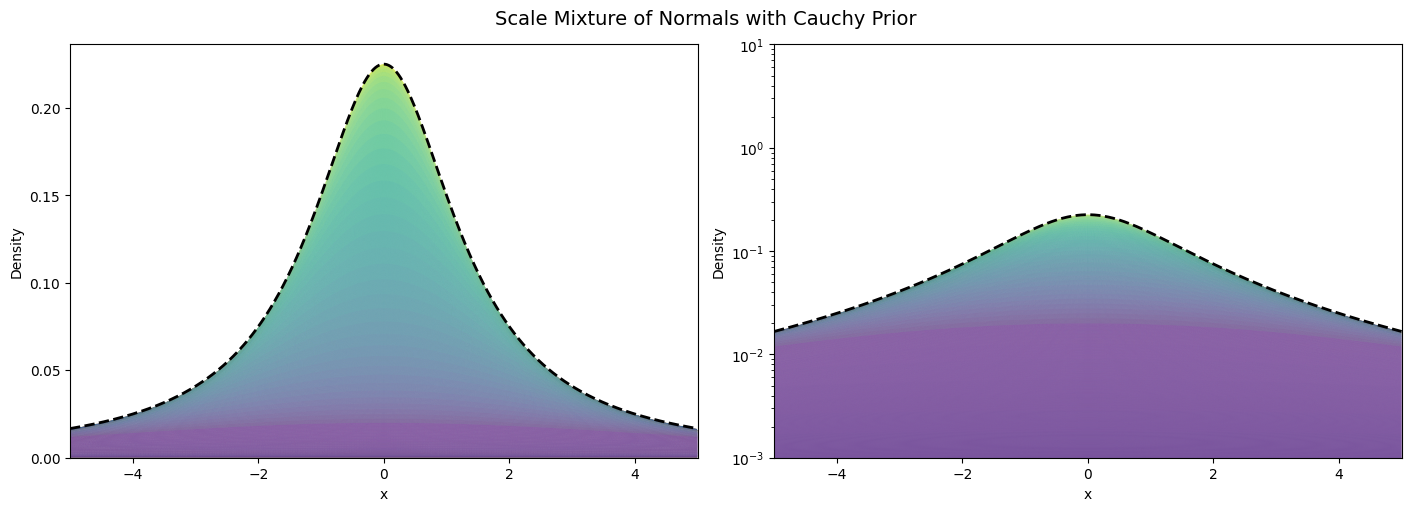

In [9]:
title = f'Scale Mixture of Normals with Cauchy Prior'
fig = plot_pdf_components(r=-1, eta=-2, scale=1, components=3000, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), debug=True, prior_pdf=stats.cauchy(0,np.sqrt(2)).pdf, title=title, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_cauchy.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# Student T $\nu = 2$

[10.49205869  4.98328865  3.1401736   2.2124622   1.6497953   1.2682994
  0.98853213  0.76965527  0.58659693  0.41703239]


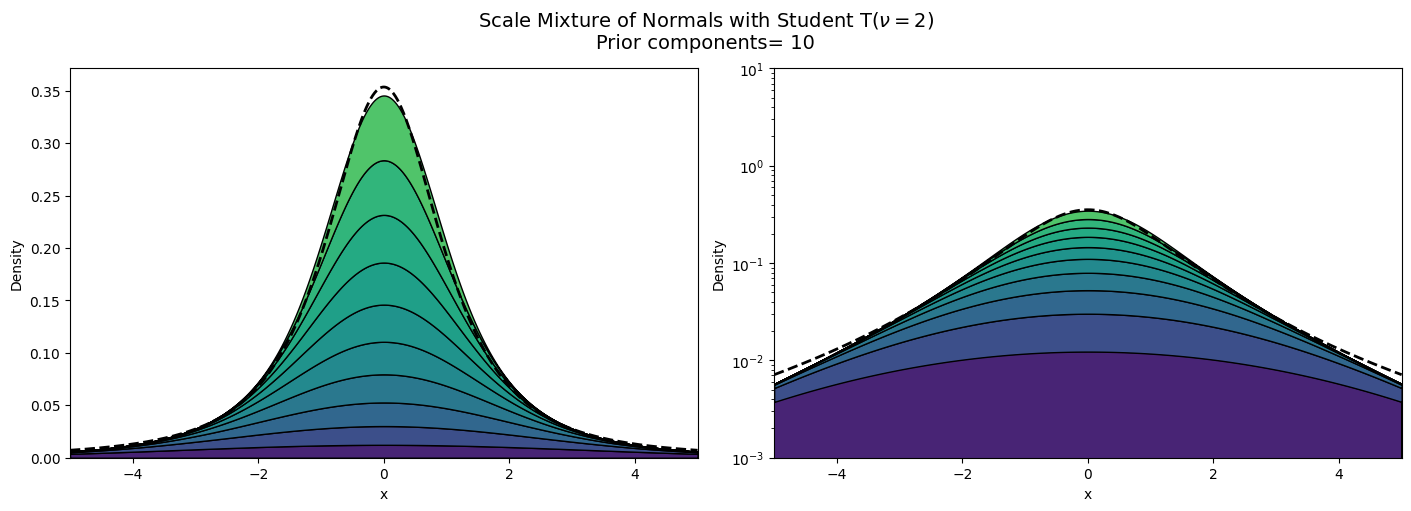

In [10]:
title = r'Scale Mixture of Normals with Student T($\nu = 2$)' + f'\nPrior components= 10'
fig = plot_pdf_components(r=-1, eta=-2.5, scale=1, components=10, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), title =title, debug=True, prior_pdf=stats.t(df = 2).pdf)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_student_t.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

[3.00049997e+03 1.49999994e+03 9.99833250e+02 ... 1.44757843e-01
 1.36732435e-01 1.24895387e-01]


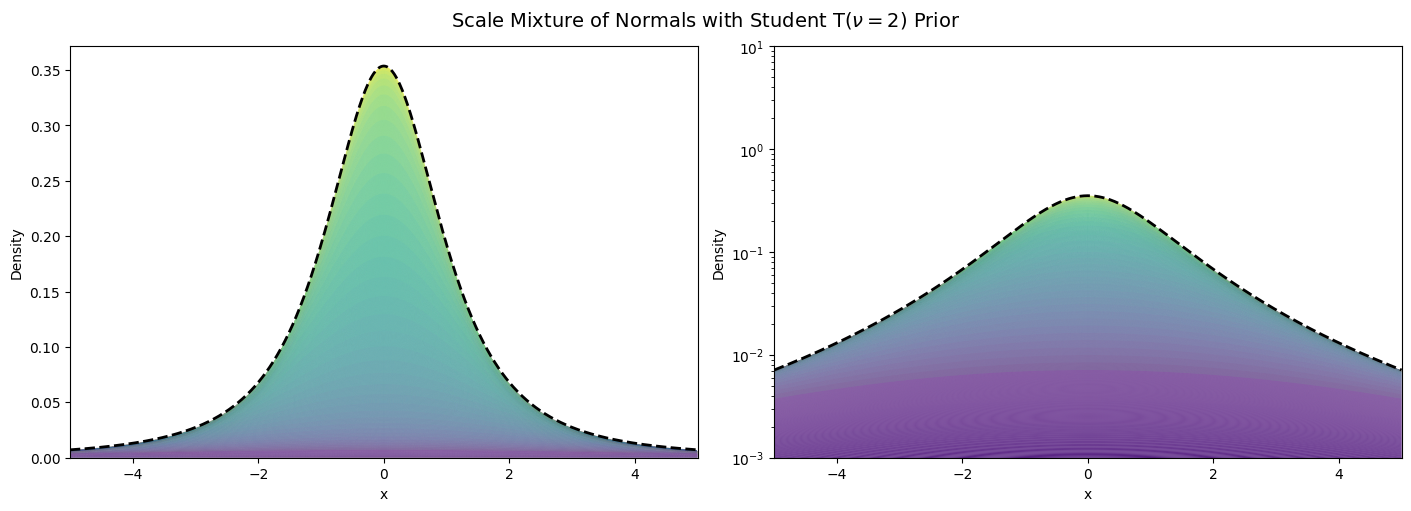

In [11]:
title = r'Scale Mixture of Normals with Student T($\nu = 2$) Prior'
fig = plot_pdf_components(r=-1, eta=-2.5, scale=1, components=3000, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), title =title, debug=True, prior_pdf=stats.t(df = 2).pdf, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_student_t.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# A

Params: 1, -1
Chebyshev bound: 22.360679774997898
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.04603906744925168


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values with new points: 0.0009957434972748258
First CDF value: 1.2854592126570933e-15
Last CDF value: 0.9999999999999987
Tail bound: 0.001
KstestResult(statistic=0.009055823175270372, pvalue=0.38280532276258683, statistic_location=-0.004824702608839171, statistic_sign=1)
[1.42910075 0.89134979 0.60148903 0.41264785 0.27964624 0.18276172
 0.11176478 0.06081527 0.02642335 0.00651914]


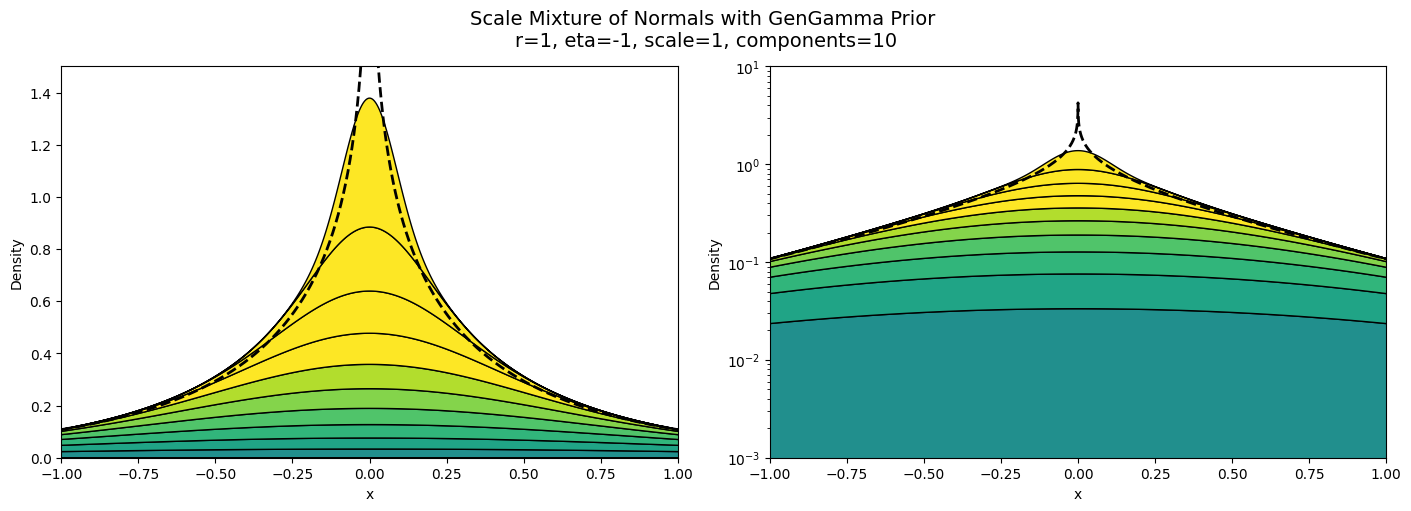

In [12]:
title = f'Scale Mixture of Normals with GenGamma Prior \nr=1, eta=-1, scale=1, components={10}'
fig = plot_pdf_components(r=1, eta=-1, scale=1, components=10, mode="equal", color_fn= color_fn, xlim=(-1, 1),  lin_lim= [0, 1.5], log_lim=(1e-3, 10), title = title,  debug=True)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_r=1_eta=1_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 1, -1
Chebyshev bound: 22.360679774997898
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.04603906744925168


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values with new points: 0.0009957434972748258
First CDF value: 1.2854592126570933e-15
Last CDF value: 0.9999999999999987
Tail bound: 0.001
KstestResult(statistic=0.013070251990440429, pvalue=0.06507045922609256, statistic_location=0.1604905211351385, statistic_sign=-1)
[6.43687770e+00 5.79028581e+00 5.41409162e+00 ... 7.84875237e-07
 3.48833337e-07 8.72083191e-08]


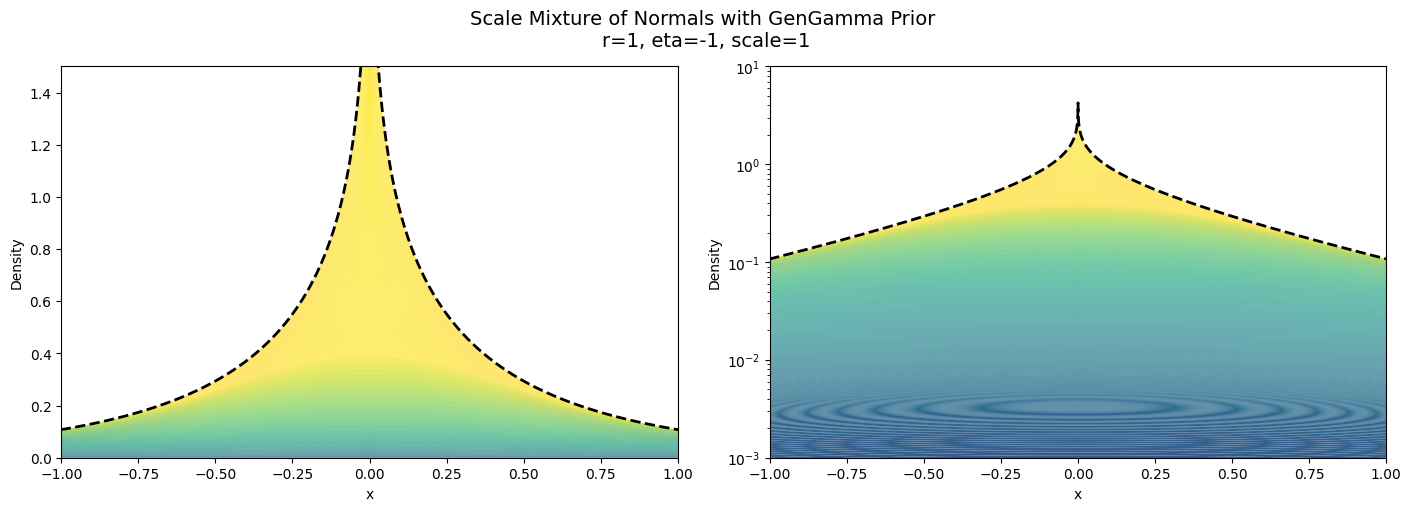

In [13]:
title = f'Scale Mixture of Normals with GenGamma Prior \nr=1, eta=-1, scale=1'
fig = plot_pdf_components(r=1, eta=-1, scale=1, components=3000, mode="equal", color_fn= color_fn, xlim=(-1, 1),  lin_lim= [0, 1.5], log_lim=(1e-3, 10), title = title, debug=True, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_r=1_eta=1_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# B

Params: 1, 2
Chebyshev bound: 59.16079783099616
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.014213646564758764
First CDF value: 7.884039416526215e-34
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.007958566234092856, pvalue=0.5481876000871061, statistic_location=-0.5710737186224304, statistic_sign=-1)
[6.15342118 5.06051277 4.36433898 3.82941643 3.37880905 2.97561873
 2.59674593 2.22273726 1.82916556 1.3632966 ]


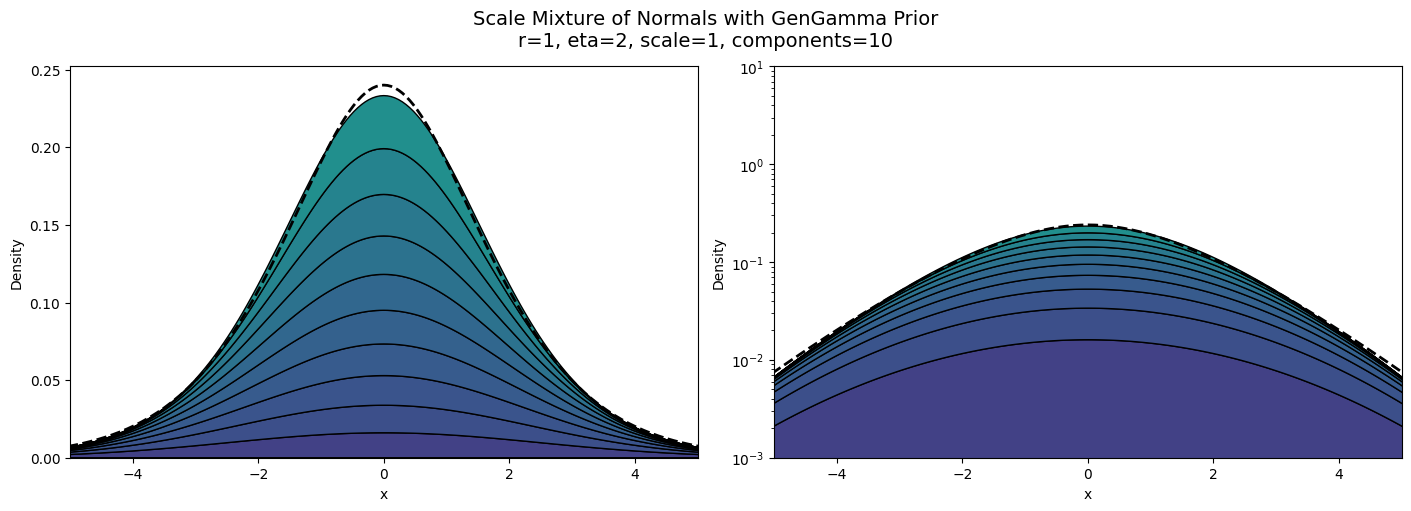

In [14]:
title = f'Scale Mixture of Normals with GenGamma Prior \nr=1, eta=2, scale=1, components={10}'
fig = plot_pdf_components(r=1, eta=2, scale=1, components=10, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), debug=True)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_r=1_eta=2_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 1, 2
Chebyshev bound: 59.16079783099616
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.014213646564758764
First CDF value: 7.884039416526215e-34
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.011544292611683216, pvalue=0.13802622362491657, statistic_location=-0.15088113099445916, statistic_sign=-1)
[13.50020905 12.65876805 12.16135375 ...  0.29921638  0.26445895
  0.21457699]


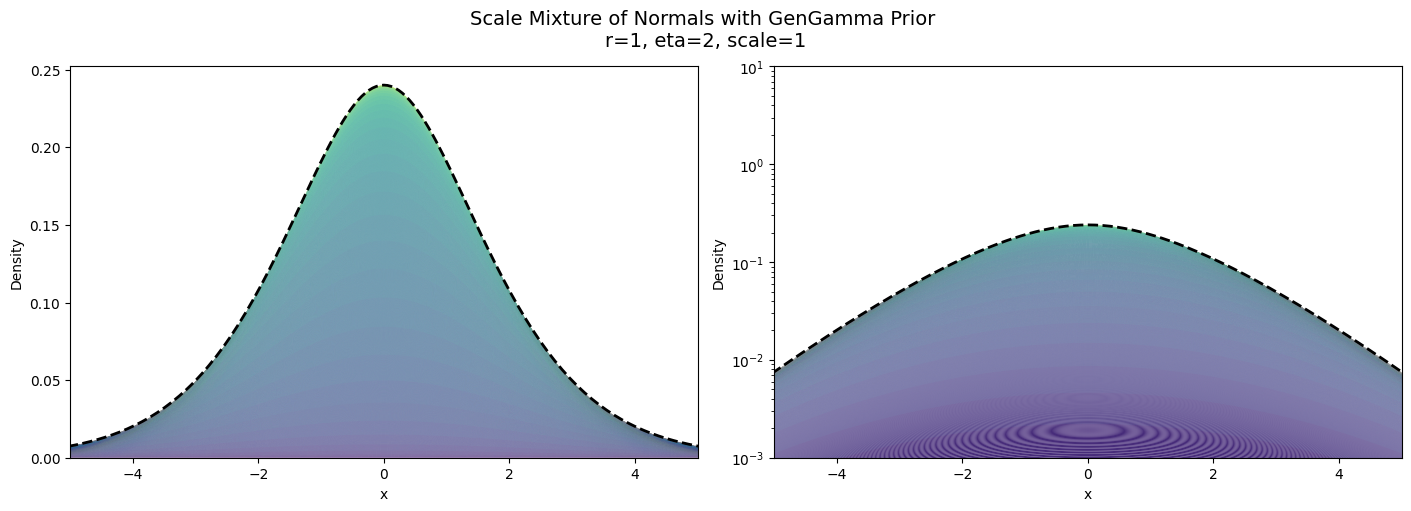

In [15]:
title = f'Scale Mixture of Normals with GenGamma Prior \nr=1, eta=2, scale=1'
fig = plot_pdf_components(r=1, eta=2, scale=1, components=3000, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), title= title, debug=True, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_r=1_eta=2_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# C

Params: 0.2, 2
Chebyshev bound: 52749.500886264315
Tail samples: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.005828559981145204
First CDF value: 3.8212144969303474e-10
Last CDF value: 0.9999999996178786
Tail bound: 0.001
KstestResult(statistic=0.007186716223970269, pvalue=0.6771789877878225, statistic_location=355.5488721437648, statistic_sign=1)
[6866734.00980798 4287767.32358618 3036950.46092983 2257054.35323129
 1710206.89923941 1298842.76200087  973900.68296481  706966.20395157
  478984.45116496  272631.42368993]


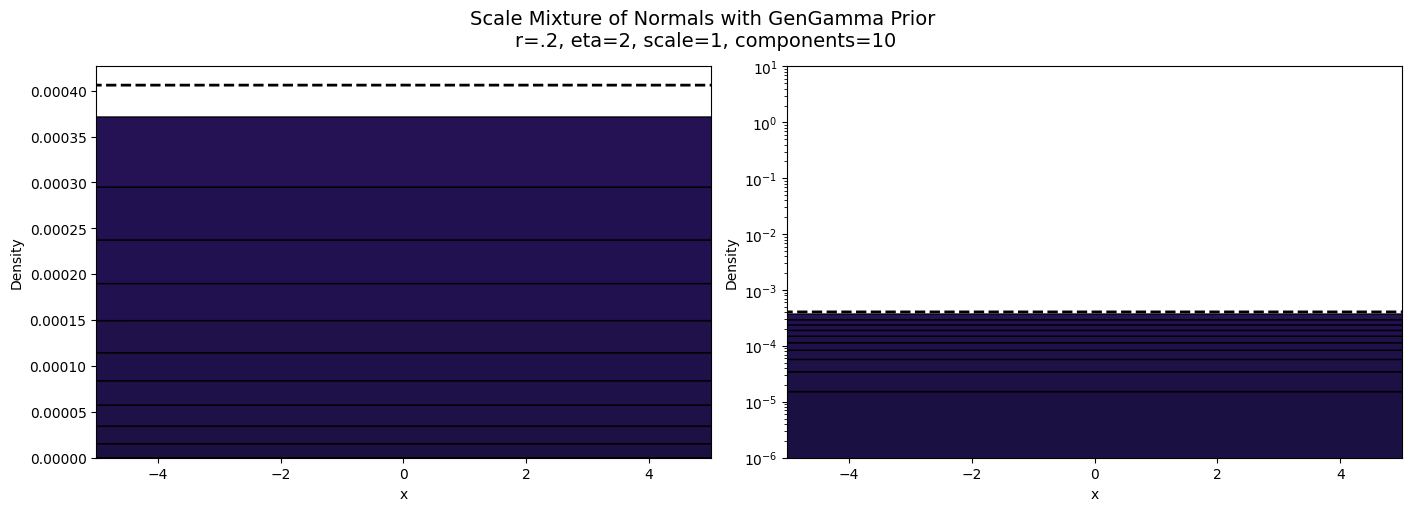

In [16]:
title = f'Scale Mixture of Normals with GenGamma Prior \nr=.2, eta=2, scale=1, components={10}'
fig = plot_pdf_components(r=.2, eta=2, scale=1, components=10, xlim = [-5, 5], color_fn= color_fn, log_lim = (1e-6, 10), title =title, mode="equal", debug=True)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_r=0.2_eta=2_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 0.2, 2
Chebyshev bound: 52749.500886264315
Tail samples: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.005828559981145204
First CDF value: 3.8212144969303474e-10
Last CDF value: 0.9999999996178786
Tail bound: 0.001
KstestResult(statistic=0.010248438032127966, pvalue=0.242660088885444, statistic_location=-932.5847357449095, statistic_sign=1)
[5.51021976e+07 4.59000532e+07 4.10087041e+07 ... 2.13586320e+04
 1.77262403e+04 1.30025930e+04]


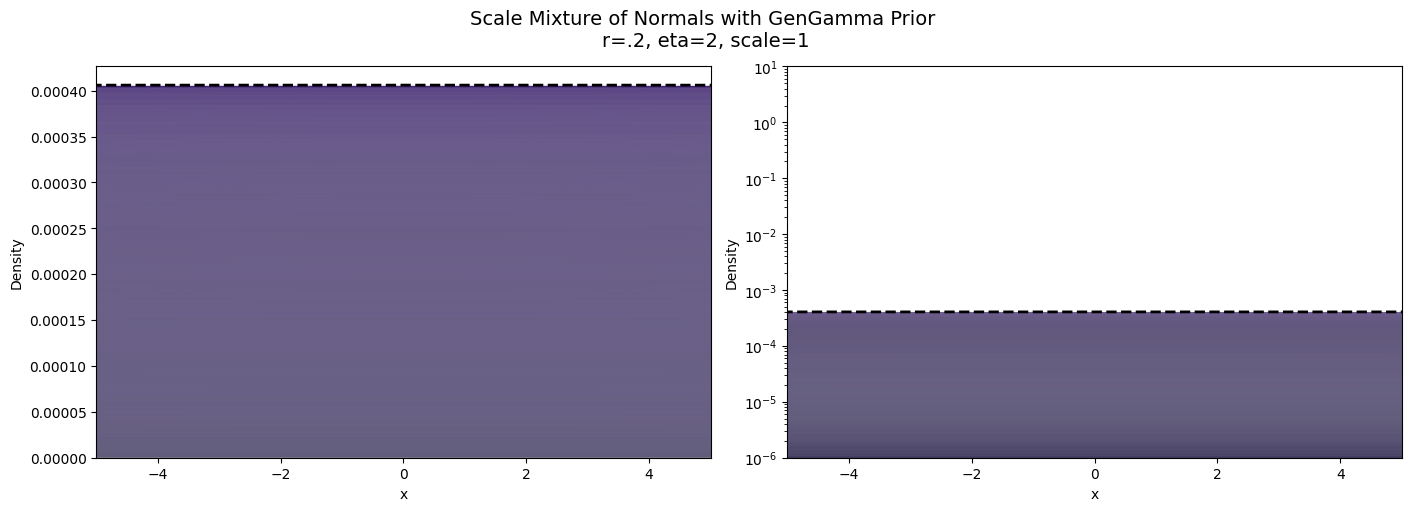

In [17]:
title = f'Scale Mixture of Normals with GenGamma Prior \nr=.2, eta=2, scale=1'
fig = plot_pdf_components(r=.2, eta=2, scale=1, components=3000, xlim = [-5, 5], color_fn= color_fn, log_lim = (1e-6, 10), title = title, mode="equal", debug=True , edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_r=0.2_eta=2_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# D

Params: 5, 5
Chebyshev bound: 31.424062636117622
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.012836042335393816
First CDF value: 9.57046655155066e-130
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.007851134085134853, pvalue=0.5658044019350494, statistic_location=-0.7979540845408427, statistic_sign=1)
[1.23810757 1.16524894 1.11103617 1.06384024 1.01930164 0.97478324
 0.92789649 0.87549071 0.81170066 0.71994407]


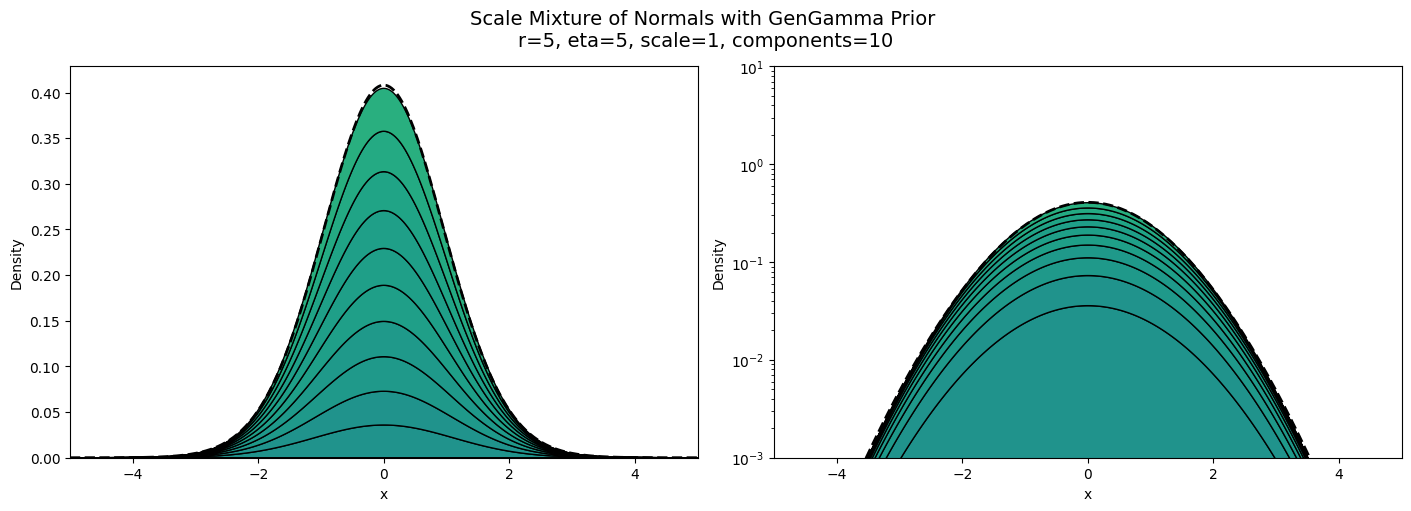

In [18]:
title = f'Scale Mixture of Normals with GenGamma Prior \nr=5, eta=5, scale=1, components={10}'
fig = plot_pdf_components(r=5, eta=5, scale=1, components=10, mode="equal", color_fn= color_fn, title = title, xlim=(-5, 5), log_lim=(1e-3, 10), debug=True)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_r=5_eta=5_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 5, 5
Chebyshev bound: 31.424062636117622
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.012836042335393816
First CDF value: 9.57046655155066e-130
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.010352373752862132, pvalue=0.23252207977695916, statistic_location=-0.524154386053133, statistic_sign=1)
[1.5448354  1.51882913 1.50271443 ... 0.35395749 0.33250935 0.29883267]


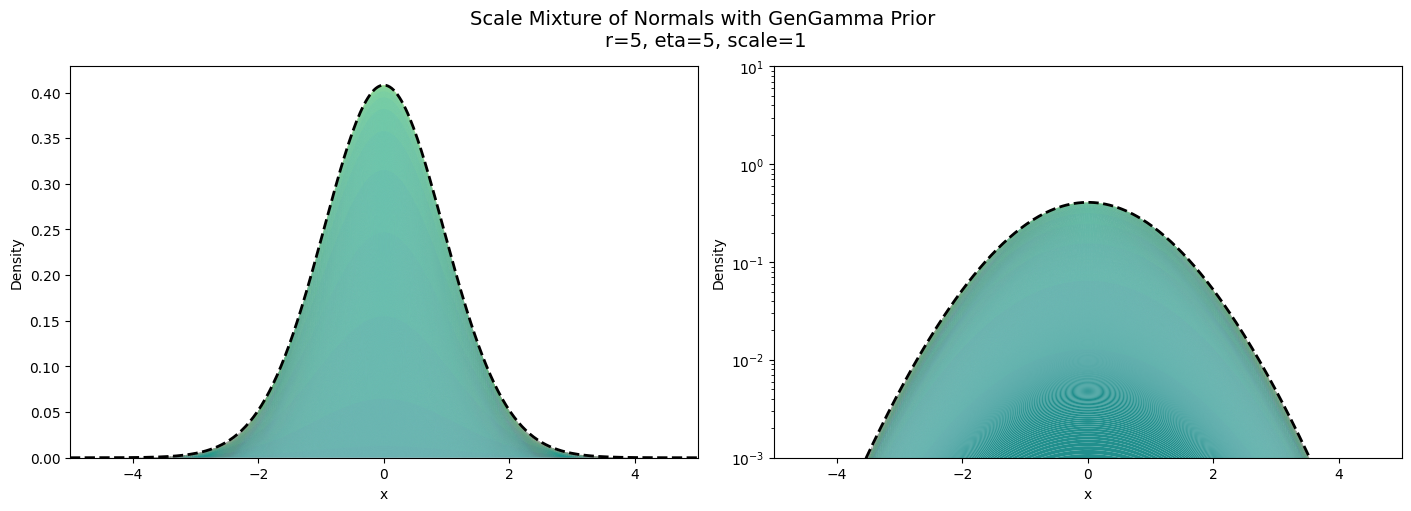

In [19]:
title = f'Scale Mixture of Normals with GenGamma Prior \nr=5, eta=5, scale=1'
fig = plot_pdf_components(r=5, eta=5, scale=1, components=3000, mode="equal", title = title, color_fn= color_fn, xlim=(-5, 5), log_lim=(1e-3, 10), debug=True, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_r=5_eta=5_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')